# Part 3

General Model: 
$$ \mu = 5 log\left( \frac{c/H_0}{10\text{pc}}(1+z)\int_0^{z} 
\frac{dz'}{\sqrt{\Omega_m(1+z'^3) + \Omega_{\Lambda}}}\right) $$

Flat Universe: $$\Omega_{\Lambda}  = 1 - \Omega_m $$

$$ \mu = 5 log\left( \frac{c/H_0}{10\text{pc}}(1+z)\int_0^{z} 
\frac{dz'}{\sqrt{\Omega_m z'^3 +  1}}\right) $$

It's a very non-linear model. \
Fit it to the data (however you want to do it, are you frequentist or Bayesian after all?).\
What are the measured value of $H_0$ and $ \Omega_m$. Are they correlated?\
How would a model without dark energy (i.e. $\Omega_m = 1$) perform? Do these data contain evidence of dark energy? (Hint: this is a model selection problem!)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
path = r"C:\Users\ricca\Documents\Unimib-Code\Astrostatistics\Notebooks\venv\Utilities"
sys.path.append(path)
import plot_settings

In [2]:
data = np.genfromtxt(r'C:\Users\ricca\Documents\Unimib-Code\Astrostatistics\Notebooks\Data\mu_z.txt', delimiter=' ')

In [3]:
z_sample  = data[:, 0]
mu_sample = data[:, 1]
dmu       = data[:, 2]

<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\m'
C:\Users\ricca\AppData\Local\Temp\ipykernel_14268\2962798895.py:3: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel("$\mu$")


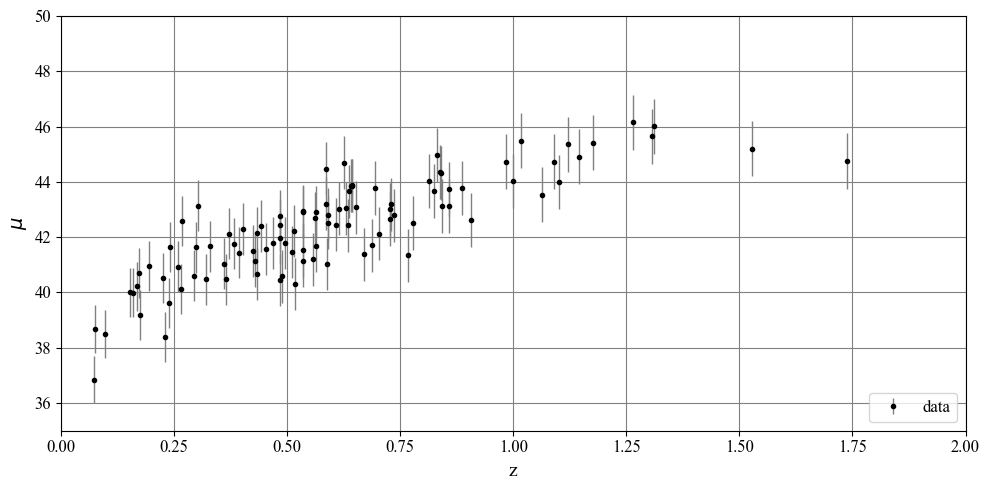

In [4]:
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50);

# MCMC

In [49]:
from scipy.integrate import quad

c = 299792.458  # velocità della luce in km/s

def integrand(zp, omega_m):
    return 1.0 / np.sqrt(omega_m * zp**3 + 1)

def mu_theoretical(z, H0, omega_m):
    mu = []
    for zi in z:
        integral, _ = quad(integrand, 0, zi, args=(omega_m,))
        dL = (c / H0) * (1 + zi) * integral  # luminosity distance in Mpc
        mu_i = 5 * np.log10(dL * 1e6 / 10)   # convert Mpc to pc and apply modulus formula
        mu.append(mu_i)
    return np.array(mu)


In [50]:
def log_likelihood(theta):
    H0, omega_m = theta
    if H0 <= 0 or not (0 <= omega_m <= 1):
        return -np.inf
    mu_model = mu_theoretical(z_sample, H0, omega_m)
    return -0.5 * np.sum(((mu_sample - mu_model) / dmu)**2 + np.log(2 * np.pi * dmu**2))


In [51]:
def log_prior(theta):
    H0, omega_m = theta
    if 50 < H0 < 100 and 0 < omega_m < 1:
        return 0.0
    return -np.inf


In [52]:
def log_posterior(theta):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta)


In [53]:
ndim = 2
nwalkers = 20
nsteps = 10000

In [54]:
initial = np.array([70, 0.3])  # H0, Omega_m
p0 = initial + 1e-2 * np.random.randn(nwalkers, ndim)

In [55]:
import emcee

In [56]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior)

In [58]:
sampler.run_mcmc(p0, nsteps, progress=True)

You must install the tqdm library to use progress indicators with emcee


State([[7.24108556e+01 6.59896737e-01]
 [7.63436650e+01 6.87970508e-01]
 [7.05970649e+01 8.37497836e-01]
 [8.27866891e+01 6.89376116e-01]
 [8.43400603e+01 5.63842033e-01]
 [7.84101704e+01 3.02503467e-01]
 [8.37012009e+01 7.87207690e-01]
 [8.43324697e+01 5.23572569e-01]
 [7.68393759e+01 1.85514773e-01]
 [7.98808006e+01 4.28832290e-01]
 [8.35050123e+01 8.64079388e-01]
 [8.30981419e+01 8.24070735e-01]
 [7.62905940e+01 5.60318538e-01]
 [7.59375606e+01 4.53967728e-01]
 [7.99559350e+01 4.17868041e-01]
 [8.51956050e+01 3.13233938e-01]
 [7.48877835e+01 2.44426135e-02]
 [7.84578354e+01 3.81394046e-01]
 [7.37127479e+01 4.35954851e-01]
 [8.12693004e+01 5.69513900e-01]], log_prob=[-135.68101282 -134.06292946 -136.63479684 -134.51391502 -134.9793151
 -134.02953584 -134.93598488 -134.9388579  -134.5075312  -133.90175971
 -134.93237104 -134.73400537 -134.17234959 -134.37736318 -133.90798512
 -135.10784462 -135.74153942 -133.9585462  -135.32229132 -134.06329522], blobs=None, random_state=('MT19937', a

In [59]:
flat_samples = sampler.get_chain(discard=1000, thin=10, flat=True)

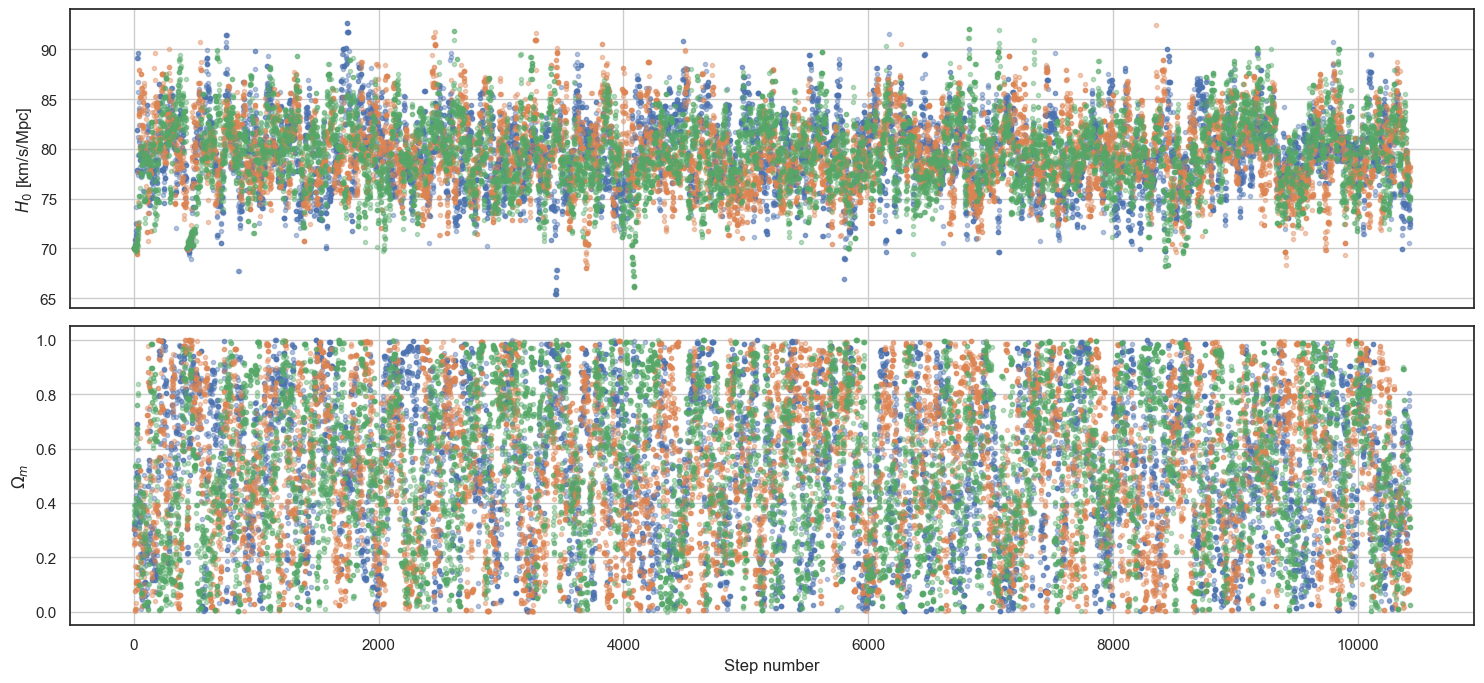

In [74]:
fig, axes = plt.subplots(ndim, figsize=(15, 7), sharex=True)
labels = [r"$H_0$ [km/s/Mpc]", r"$\Omega_m$"]

# Assuming sampler.get_chain() shape is (n_steps, n_walkers, ndim)
chain = sampler.get_chain()

for i in range(ndim):
    ax = axes[i]
    # Plot every 8th walker
    for walker in range(0, chain.shape[1], 8):
        ax.plot(chain[:, walker, i], '.', alpha=0.4)
    ax.set_ylabel(labels[i])
    ax.grid(True)

axes[-1].set_xlabel("Step number")
plt.tight_layout()


In [62]:
import corner

<>:20: SyntaxWarning: invalid escape sequence '\O'
<>:20: SyntaxWarning: invalid escape sequence '\O'
C:\Users\ricca\AppData\Local\Temp\ipykernel_14268\2308470797.py:20: SyntaxWarning: invalid escape sequence '\O'
  fig.suptitle("Posterior Distributions for $H_0$ and $\Omega_m$", fontsize=16)


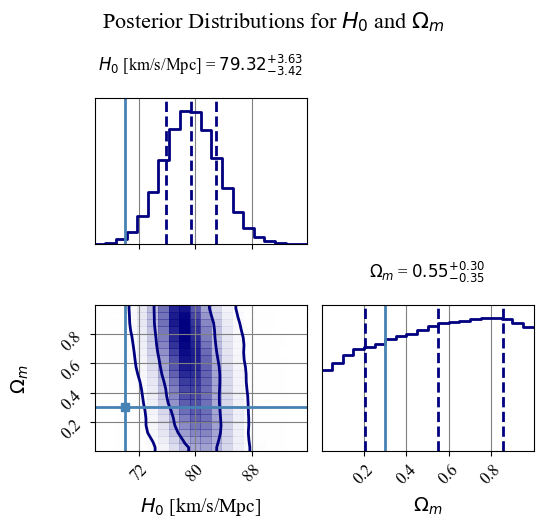

In [64]:
fig = corner.corner(
    flat_samples,
    labels=[r"$H_0$ [km/s/Mpc]", r"$\Omega_m$"],
    truths=[70, 0.3],  # Optional: if you want to show true/expected values
    show_titles=True,
    title_fmt=".2f",
    title_kwargs={"fontsize": 12},
    label_kwargs={"fontsize": 14},
    quantiles=[0.16, 0.5, 0.84],
    levels=(0.68, 0.95),
    plot_contours=True,
    plot_density=True,
    plot_datapoints=False,  # cleaner look
    color="navy",
    smooth=1.0,  # smoothing for density
    smooth1d=1.0,
    figsize=(6, 6),
)

fig.suptitle("Posterior Distributions for $H_0$ and $\Omega_m$", fontsize=16)
plt.tight_layout()
plt.show()


In [66]:
import numpy as np

# Assuming `flat_samples` is of shape (n_samples, 2) → [H0, Omega_m]
param_names = ['H0', 'Omega']
results = []

for i in range(flat_samples.shape[1]):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    results.append((mcmc[1], q[0], q[1]))
    print(f"{param_names[i]} = {mcmc[1]:.2f} (+{q[1]:.2f}, -{q[0]:.2f})")


H0 = 79.32 (+3.63, -3.42)
Omega = 0.55 (+0.30, -0.35)


In [70]:
corr_matrix = np.corrcoef(flat_samples.T)

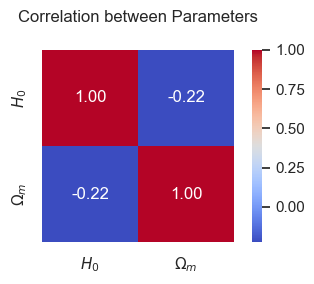

In [71]:
import seaborn as sns

sns.set(style="white")
fig, ax = plt.subplots(figsize=(4, 3))

sns.heatmap(corr_matrix, annot=True, fmt=".2f",
            xticklabels=[r"$H_0$", r"$\Omega_m$"],
            yticklabels=[r"$H_0$", r"$\Omega_m$"],
            cmap="coolwarm", cbar=True, square=True, ax=ax)

plt.title("Correlation between Parameters")
plt.tight_layout()
plt.show()
